In [168]:
import networkx as nx
import os
import re
import datetime
import pprint
import json 
import pandas as pd
import math
from matplotlib import pyplot as plt

In [ ]:
# build a dict of metadata entries by email with a path to the full email
# !!! WARNING This WILL NOT work without the enron dataset extracted to the path below. WARNING !!!
# !!! WARNING IF you have already populated directory.json, skip to the 6th cell !!!

base_path = os.getcwd() + '/maildir'

messages = {}
errors = {'failures': [], 'not_emails': []}

def navigate_directories(path):
    # list the current directory
    contents = os.listdir(path)
    # for each item in the directory
    for entry in contents:
        entry_path = path + '/' + entry
        # if it's a directory, run this function again
        if os.path.isdir(entry_path):
            navigate_directories(entry_path)
        # if it's a file, extract the metadata
        else:
            build_dict(entry_path)

def build_dict(path):
    # open the file
    with open(path, 'r') as doc:
        try:
            contents = doc.read()
        
            # capture the messageid
            m = re.compile(r'^Message-ID: <(.*?)>.*')
            re_msg_id = m.match(contents)
            msg_id = re_msg_id.group(1)
            
            # if the messageid hasn't been parsed yet:
            if not msg_id in messages.keys():
                # add an entry with the messageid as the key, and a dict as the value with 'path': path as an entry
                messages[msg_id] = {'path': path}
        except UnicodeDecodeError:
            errors['failures'].append(path)
        except AttributeError:
            errors['not_emails'].append(path)



In [ ]:
navigate_directories(base_path)

In [ ]:
#for each email, add the date, the sender, and the recipients to the messages dict. 
for message in messages:
    with open(messages[message]['path'], 'r') as doc:
        email = doc.read()
        address = r"[\w!#\$%&'\*\+-/=\?\^_`\{\}\|~\.]+@[\w!#\$%&'\*\+-/=\?\^_`\{\}\|~\.]+\.[\w!#\$%&'\*\+-/=\?\^_`\{\}\|~\.]+"
        from_line = r"From: .*?(" + address + r")"
        to_line = r"To: ((" + address + "[\s,]+)+)"
        date_line = r"Date: ([a-zA-Z]+, \d+ [a-zA-Z]+ \d+ \d+:\d+:\d+ [-\+]?\d+)"
        #regex search From:
        re_from = re.search(from_line, email)
        try:
            messages[message]['from'] = re_from.group(1)
        except:
            print(f"No from email. Message path: {messages[message]['path']}")
        #regex search To: repeating group
        re_to = re.search(to_line, email)
        if re_to:
            messages[message]['to'] = re.split(r"[\s,]+", re_to.group(1))[:-1]
        else:
            messages[message]['to'] = []
        #regex search date, convert to datetime
        re_date = re.search(date_line, email)
        try:
            msg_time = datetime.datetime.strptime(re_date.group(1), '%a, %d %b %Y %H:%M:%S %z')
            messages[message]['time'] = msg_time
        except:
            print(f"Could not parse date for {messages[message]['path']}")

In [ ]:
# Load all the data into a JSON for faster setup in the future.

directory = {
    'messages': messages,
    'failures': errors['failures'],
    'not_emails': errors['not_emails']
}

with open(os.getcwd() + '/results/directory.json', 'w') as f:
    json.dump(directory, f, default=str)

In [2]:
# !!! USE THIS TO LOAD IN THE DATA FASTER - skip the 2nd - 5th blocks !!!

directory = {}

def datetime_parser(json_dict):
    if 'time' in json_dict:
        try:
            json_dict['time'] = datetime.datetime.strptime(json_dict['time'], '%Y-%m-%d %H:%M:%S%z')
        except:
            print('Entry failed:')
            pprint.pprint(json_dict)
    return json_dict 

with open(os.getcwd() + '/results/directory.json', 'r') as f:
   directory = json.load(f, object_hook=datetime_parser)

In [19]:
# Load into Pandas
emails = pd.DataFrame.from_dict(directory['messages'], orient='index')
emails.rename(columns={'from': 'From', 'to': 'To'}, inplace=True)
emails.head()

,path,From,To,time
26474922.1075852468285.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,john.shelk@enron.com,[charles.yeung@enron.com],2001-10-05 08:21:31-07:00
24576280.1075861591387.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,john.shelk@enron.com,"[d..steffes@enron.com, linda.robertson@enron.c...",2001-11-02 05:33:16-08:00
16152007.1075852468365.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,john.shelk@enron.com,"[richard.shapiro@enron.com, d..steffes@enron.c...",2001-09-25 09:25:07-07:00
10118998.1075852468340.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,john.shelk@enron.com,"[joe.connor@enron.com, richard.ingersoll@enron...",2001-09-28 12:11:10-07:00
18295099.1075852468262.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,john.shelk@enron.com,"[richard.shapiro@enron.com, linda.robertson@en...",2001-10-11 08:31:11-07:00


In [64]:
#make a new frame that lists each single-recipient from-to relationship by frequency.  We're looking for more "genuine" communications, vice memos.
def strip_list(row):
    row.To = row.To[0]
    return row
personal_emails = emails[emails.To.map(len) == 1]
personal_emails.apply(lambda row: strip_list(row), axis='columns')
personal_emails


,path,From,To,time
26474922.1075852468285.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,john.shelk@enron.com,charles.yeung@enron.com,2001-10-05 08:21:31-07:00
12228598.1075852468116.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,yolanda.lopez@enron.com,d..steffes@enron.com,2001-08-09 14:01:39-07:00
26675013.1075852467950.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,ldcolburn@mediaone.net,jsteffe@enron.com,2001-10-15 11:48:21-07:00
18110306.1075852468020.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,kathy.dodgen@enron.com,distribution@enron.com,2001-07-09 19:16:00-07:00
32573612.1075852527083.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,john.shelk@enron.com,d..steffes@enron.com,2001-08-14 14:13:31-07:00
...,...,...,...,...
28795989.1075852092444.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,fool@motleyfool.com,benjamin.rogers@enron.com,2001-05-15 14:00:00-07:00
18496163.1075857280694.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,fool@motleyfool.com,benjamin.rogers@enron.com,2000-12-11 11:22:00-08:00
33543789.1075852092884.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,fool@motleyfool.com,benjamin.rogers@enron.com,2001-04-24 11:31:00-07:00
18159478.1075852092417.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,fool@motleyfool.com,benjamin.rogers@enron.com,2001-05-15 19:25:00-07:00


In [231]:
# Since we're using this as a representation of real-people employees, remove emails that begin or end outside of "enron.com"
personal_emails = personal_emails[personal_emails['From'].str.contains('enron.com') & personal_emails['To'].str.contains('enron.com')]
personal_emails

,path,From,To,time
26474922.1075852468285.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,john.shelk@enron.com,charles.yeung@enron.com,2001-10-05 08:21:31-07:00
12228598.1075852468116.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,yolanda.lopez@enron.com,d..steffes@enron.com,2001-08-09 14:01:39-07:00
18110306.1075852468020.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,kathy.dodgen@enron.com,distribution@enron.com,2001-07-09 19:16:00-07:00
32573612.1075852527083.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,john.shelk@enron.com,d..steffes@enron.com,2001-08-14 14:13:31-07:00
2082810.1075852465959.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,guillermo.canovas@enron.com,d..steffes@enron.com,2001-09-09 14:50:37-07:00
...,...,...,...,...
20546590.1075852090072.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,jaime.gualy@enron.com,benjamin.rogers@enron.com,2001-09-13 08:32:46-07:00
8899267.1075855100844.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,chairman.ken@enron.com,dl-ga-all_enron_worldwide@enron.com,2001-11-08 15:35:50-08:00
31922600.1075855100797.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,chris.walker@enron.com,benjamin.rogers@enron.com,2001-11-05 15:29:00-08:00
1430008.1075860718128.JavaMail.evans@thyme,/home/cyfir/mst688/applications/enron/maildir/...,jaime.gualy@enron.com,benjamin.rogers@enron.com,2001-09-17 08:55:30-07:00


In [232]:
interactions = personal_emails.groupby(['From', 'To']).size().reset_index()
# Remove all cases where sender and recipient are the same
interactions = interactions[interactions['From'] != interactions['To']]
interactions.rename(columns={0: 'count'}, inplace=True)
interactions

,From,To,count
0,'todd'.delahoussaye@enron.com,susan.bailey@enron.com,1
1,.chen@enron.com,kam.keiser@enron.com,1
2,.daigle@enron.com,peggy.miller@enron.com,1
3,.elizondo@enron.com,kenneth.lay@enron.com,1
4,.hall@enron.com,alan.comnes@enron.com,2
...,...,...,...
31955,zimin.lu@enron.com,zhiyong.wei@enron.com,4
31956,zimin.lu@enron.com,zhiyun.yang@enron.com,2
31958,zionette.vincent@enron.com,stacey.white@enron.com,6
31959,zipper@enron.com,john.lavorato@enron.com,2


In [233]:
# Remove one-off interactions from the system. 
interactions = interactions[interactions['count'] > 1]
interactions

,From,To,count
4,.hall@enron.com,alan.comnes@enron.com,2
8,.hall@enron.com,carol.st.@enron.com,2
9,.hall@enron.com,center.dl-portland@enron.com,7
10,.hall@enron.com,christian.yoder@enron.com,2
11,.hall@enron.com,diana.scholtes@enron.com,4
...,...,...,...
31955,zimin.lu@enron.com,zhiyong.wei@enron.com,4
31956,zimin.lu@enron.com,zhiyun.yang@enron.com,2
31958,zionette.vincent@enron.com,stacey.white@enron.com,6
31959,zipper@enron.com,john.lavorato@enron.com,2


In [234]:
# We also need a way to lessen the weight of "interactions" that are one-sided, like automated mailers. Let's strip out interactions where there isn't a single response in the opposite direction.
# Yes, I know this is horribly inefficient. I can't think of a better way to do this.
def check_reciprocity(row):
    is_reciprocal = not (interactions[(interactions['To'] == row['From']) & (interactions['From'] == row['To'])].empty)
    return is_reciprocal

interactions['reciprocal'] = interactions.apply(lambda row: check_reciprocity(row), axis='columns')



In [235]:
reciprocals = interactions[interactions['reciprocal'] == True]
reciprocals

,From,To,count,reciprocal
261,a..bowen@enron.com,m..love@enron.com,2,True
262,a..campos@enron.com,chris.germany@enron.com,4,True
267,a..garcia@enron.com,sara.shackleton@enron.com,6,True
271,a..hope@enron.com,michelle.cash@enron.com,3,True
275,a..howard@enron.com,james.centilli@enron.com,2,True
...,...,...,...,...
31929,zimin.lu@enron.com,j.kaminski@enron.com,5,True
31935,zimin.lu@enron.com,john.lavorato@enron.com,17,True
31944,zimin.lu@enron.com,paulo.issler@enron.com,6,True
31948,zimin.lu@enron.com,stinson.gibner@enron.com,31,True


In [236]:

# Weaken the overweighting of serial emailers by applying a log function to the count.
reciprocals['log'] = reciprocals.apply(lambda row: math.log10(row['count']), axis='columns')
reciprocals


,From,To,count,reciprocal,log
261,a..bowen@enron.com,m..love@enron.com,2,True,0.301030
262,a..campos@enron.com,chris.germany@enron.com,4,True,0.602060
267,a..garcia@enron.com,sara.shackleton@enron.com,6,True,0.778151
271,a..hope@enron.com,michelle.cash@enron.com,3,True,0.477121
275,a..howard@enron.com,james.centilli@enron.com,2,True,0.301030
...,...,...,...,...,...
31929,zimin.lu@enron.com,j.kaminski@enron.com,5,True,0.698970
31935,zimin.lu@enron.com,john.lavorato@enron.com,17,True,1.230449
31944,zimin.lu@enron.com,paulo.issler@enron.com,6,True,0.778151
31948,zimin.lu@enron.com,stinson.gibner@enron.com,31,True,1.491362


In [237]:
# Focus on the strongest bonds
def proportion_count(row):
    total_emails = emailer_activity[emailer_activity['From'] == row['From']]['count']
    proportion = row['count'] / total_emails
    return proportion.array[0]
emailer_activity = reciprocals.groupby(['From'])['count'].sum().reset_index()
reciprocals['proportion'] = reciprocals.apply(lambda row: proportion_count(row), axis='columns')
reciprocals['weight'] = reciprocals.apply(lambda row: row['proportion'] * row['log'], axis='columns')
reciprocals

,From,To,count,reciprocal,log,proportion,weight
261,a..bowen@enron.com,m..love@enron.com,2,True,0.301030,1.000000,0.301030
262,a..campos@enron.com,chris.germany@enron.com,4,True,0.602060,1.000000,0.602060
267,a..garcia@enron.com,sara.shackleton@enron.com,6,True,0.778151,1.000000,0.778151
271,a..hope@enron.com,michelle.cash@enron.com,3,True,0.477121,1.000000,0.477121
275,a..howard@enron.com,james.centilli@enron.com,2,True,0.301030,0.024390,0.007342
...,...,...,...,...,...,...,...
31929,zimin.lu@enron.com,j.kaminski@enron.com,5,True,0.698970,0.045045,0.031485
31935,zimin.lu@enron.com,john.lavorato@enron.com,17,True,1.230449,0.153153,0.188447
31944,zimin.lu@enron.com,paulo.issler@enron.com,6,True,0.778151,0.054054,0.042062
31948,zimin.lu@enron.com,stinson.gibner@enron.com,31,True,1.491362,0.279279,0.416506


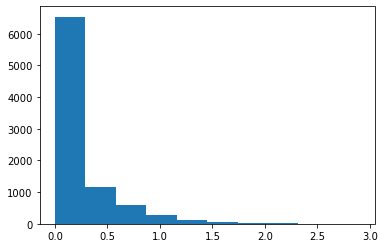

In [238]:
# Check the distribution of interaction frequencies using a histogram. 
histogram = plt.hist(reciprocals['weight'].tolist())

In [246]:
import statistics as st
stdev_margin = st.stdev(reciprocals['weight'].tolist()) + reciprocals['weight'].median()
reciprocals = reciprocals[reciprocals['weight'] > stdev_margin]
reciprocals

,From,To,count,reciprocal,log,proportion,weight
262,a..campos@enron.com,chris.germany@enron.com,4,True,0.602060,1.000000,0.602060
267,a..garcia@enron.com,sara.shackleton@enron.com,6,True,0.778151,1.000000,0.778151
271,a..hope@enron.com,michelle.cash@enron.com,3,True,0.477121,1.000000,0.477121
284,a..howard@enron.com,rod.hayslett@enron.com,26,True,1.414973,0.317073,0.448650
298,a..lindholm@enron.com,tracy.geaccone@enron.com,3,True,0.477121,1.000000,0.477121
...,...,...,...,...,...,...,...
31904,zhiyong.wei@enron.com,geoff.storey@enron.com,18,True,1.255273,0.333333,0.418424
31908,zhiyong.wei@enron.com,louise.kitchen@enron.com,30,True,1.477121,0.555556,0.820623
31913,zhiyun.yang@enron.com,w..white@enron.com,3,True,0.477121,1.000000,0.477121
31948,zimin.lu@enron.com,stinson.gibner@enron.com,31,True,1.491362,0.279279,0.416506


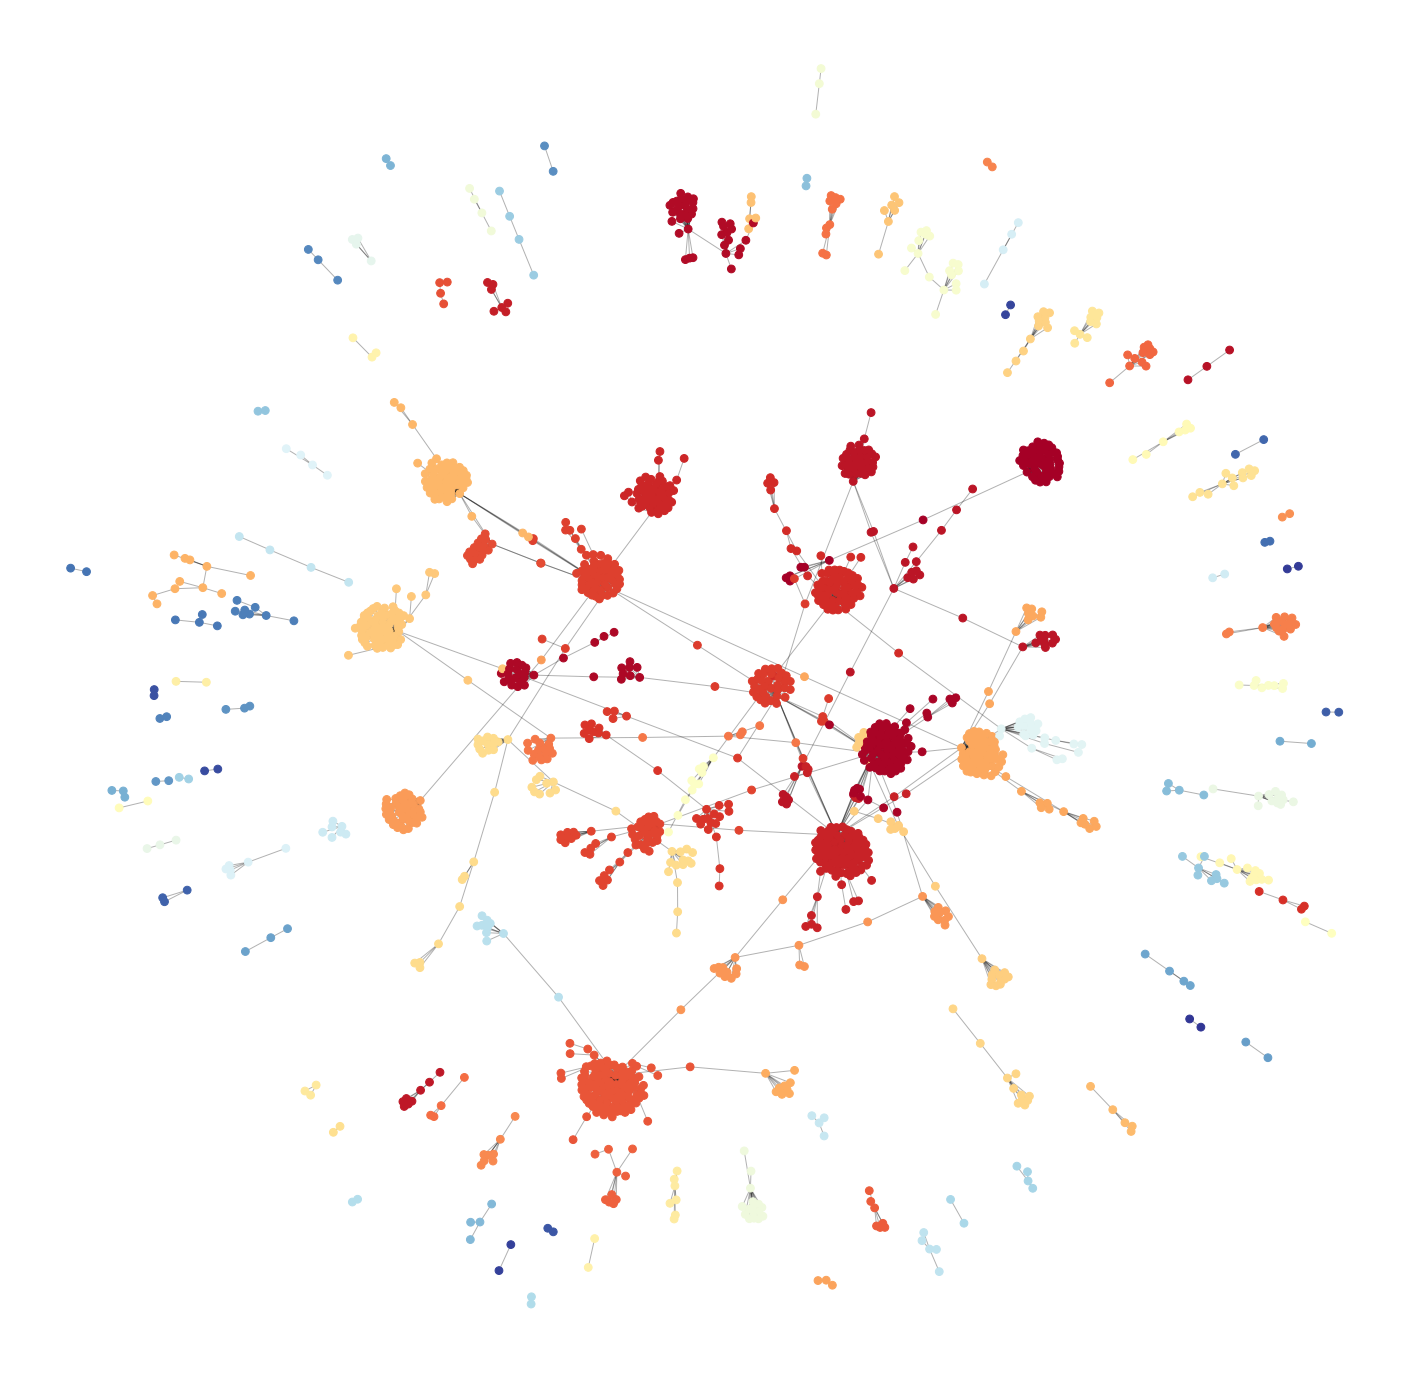

In [257]:
# Create our graph
import community

graph = nx.from_pandas_edgelist(reciprocals, source='From', target='To', edge_attr='weight', create_using=nx.dorogovtsev_goltsev_mendes_graph(3))

partition = community.best_partition(graph)
pos = nx.spring_layout(graph)
plt.figure(figsize=(25,25))
plt.axis('off')
nx.draw_networkx_nodes(graph, pos, node_size=6, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(graph, pos, alpha=0.3)
plt.show(graph)

In [269]:
names = ['lay', 'skilling', 'fastow', 'kopper', 'causey', 'glisan', 'koenig', 'rieker', 'lawyer', 'delainey', 'despain', 'forney', 'hirko', 'rice', 'shelby', 'hannon', 'howard', 'boyle']
email_addresses = list(graph.nodes())
key_nodes = []
for address in email_addresses:
    for name in names:
        if re.search(name, address):
            key_nodes.append(address)
key_nodes

['a..howard@enron.com',
 'm..forney@enron.com',
 'beatrice.reyna@enron.com',
 'brent.price@enron.com',
 'david.delainey@enron.com',
 'christi.nicolay@enron.com',
 'clay.harris@enron.com',
 'clayton.vernon@enron.com',
 'erin.rice@enron.com',
 'howard.fromer@enron.com',
 'jeff.skilling@enron.com',
 'john.forney@enron.com',
 'kevin.hannon@enron.com',
 'l..nicolay@enron.com',
 'larry.lawyer@enron.com',
 'laynie.east@enron.com',
 'mark.koenig@enron.com',
 'mark.lay@enron.com',
 'patrice.mims@enron.com',
 'r..price@enron.com',
 'richard.causey@enron.com',
 'sean.boyle@enron.com',
 'shannon.mcpearson@enron.com',
 'w..delainey@enron.com',
 'wade.price@enron.com']

In [277]:
false_positives = [
    'sean.boyle@enron.com',
    'howard.fromer@enron.com',
    'w..delainey@enron.com',
    'brent.price@enron.com',
    'beatrice.reyna@enron.com',
    'erin.rice@enron.com',
    'patrice.mims@enron.com',
    'r..price@enron.com',
    'wade.price@enron.com',
    'w..delainey@enron.com',
    'christi.nicolay@enron.com',
    'clay.harris@enron.com',
    'clayton.vernon@enron.com',
    'l..nicolay@enron.com',
    'laynie.east@enron.com',
    'mark.lay@enron.com',
    'shannon.mcpearson@enron.com'
]

for name in false_positives:
    try:
        key_nodes.remove(name)
    except:
        pass
key_nodes

['a..howard@enron.com',
 'm..forney@enron.com',
 'david.delainey@enron.com',
 'jeff.skilling@enron.com',
 'john.forney@enron.com',
 'kevin.hannon@enron.com',
 'larry.lawyer@enron.com',
 'mark.koenig@enron.com',
 'richard.causey@enron.com']

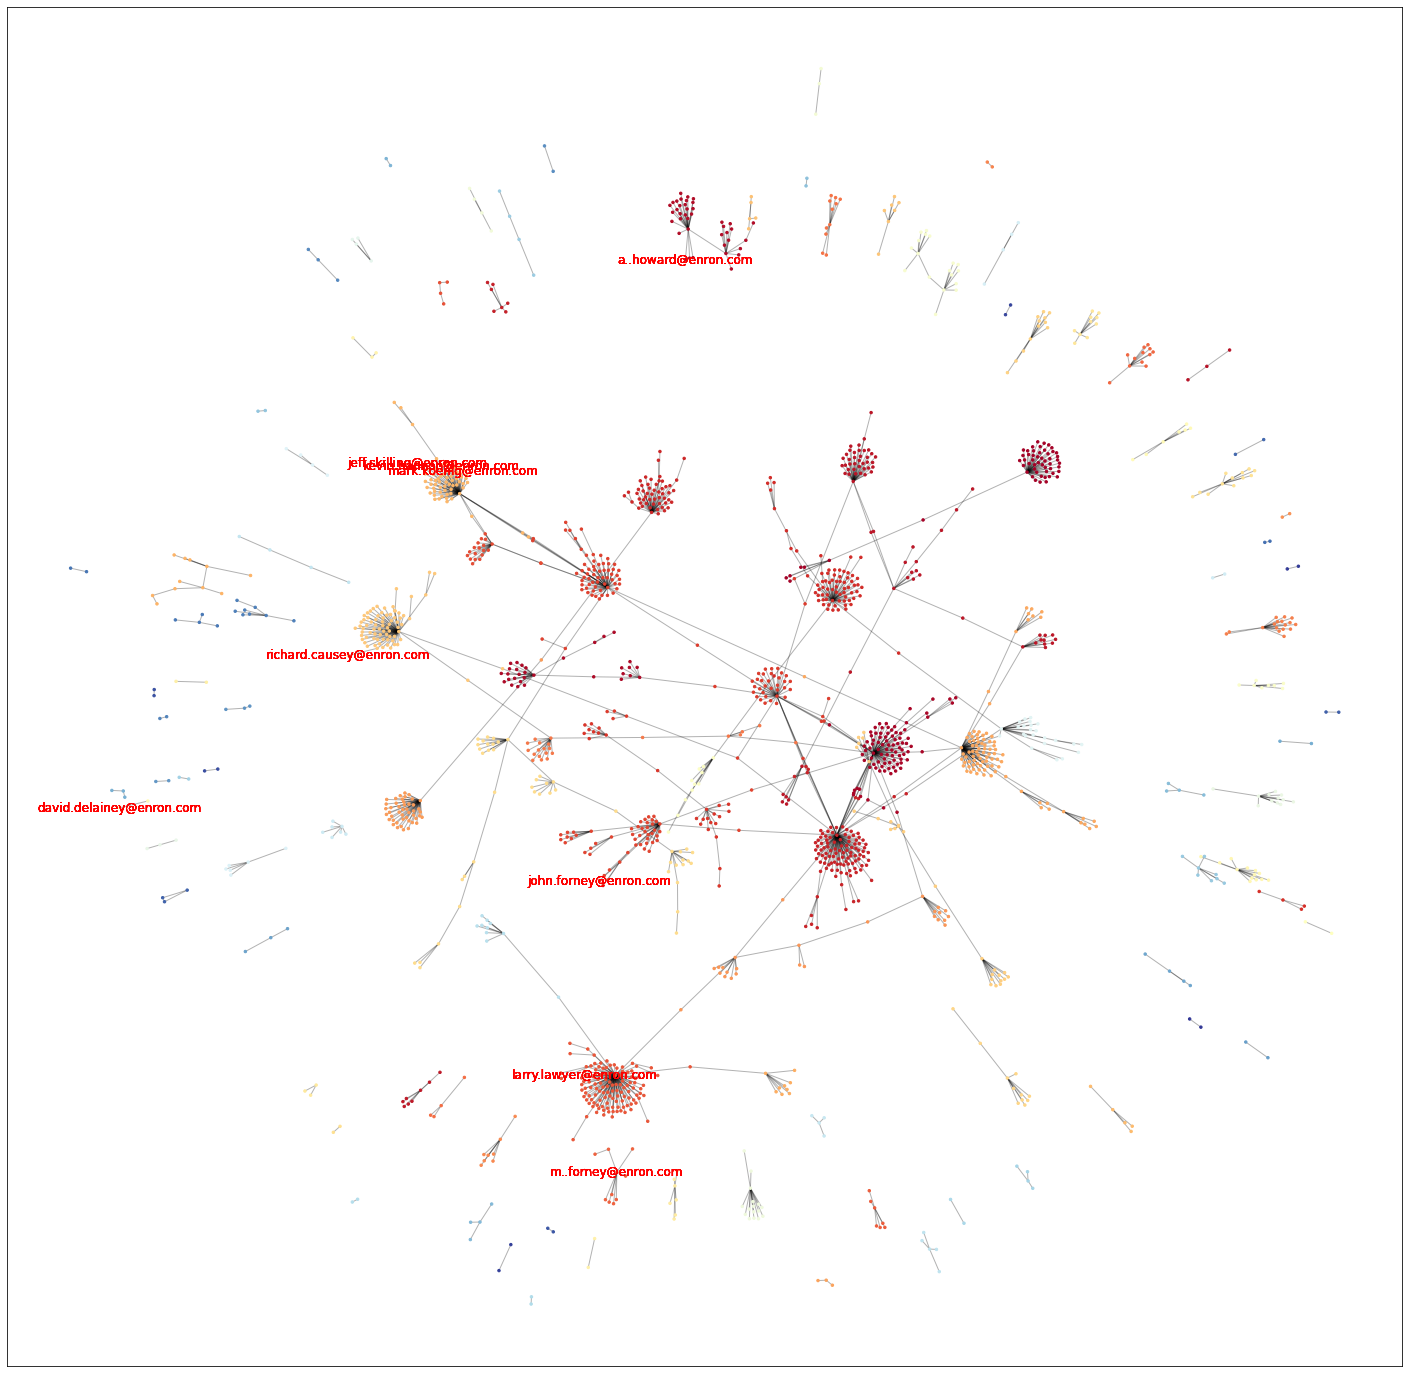

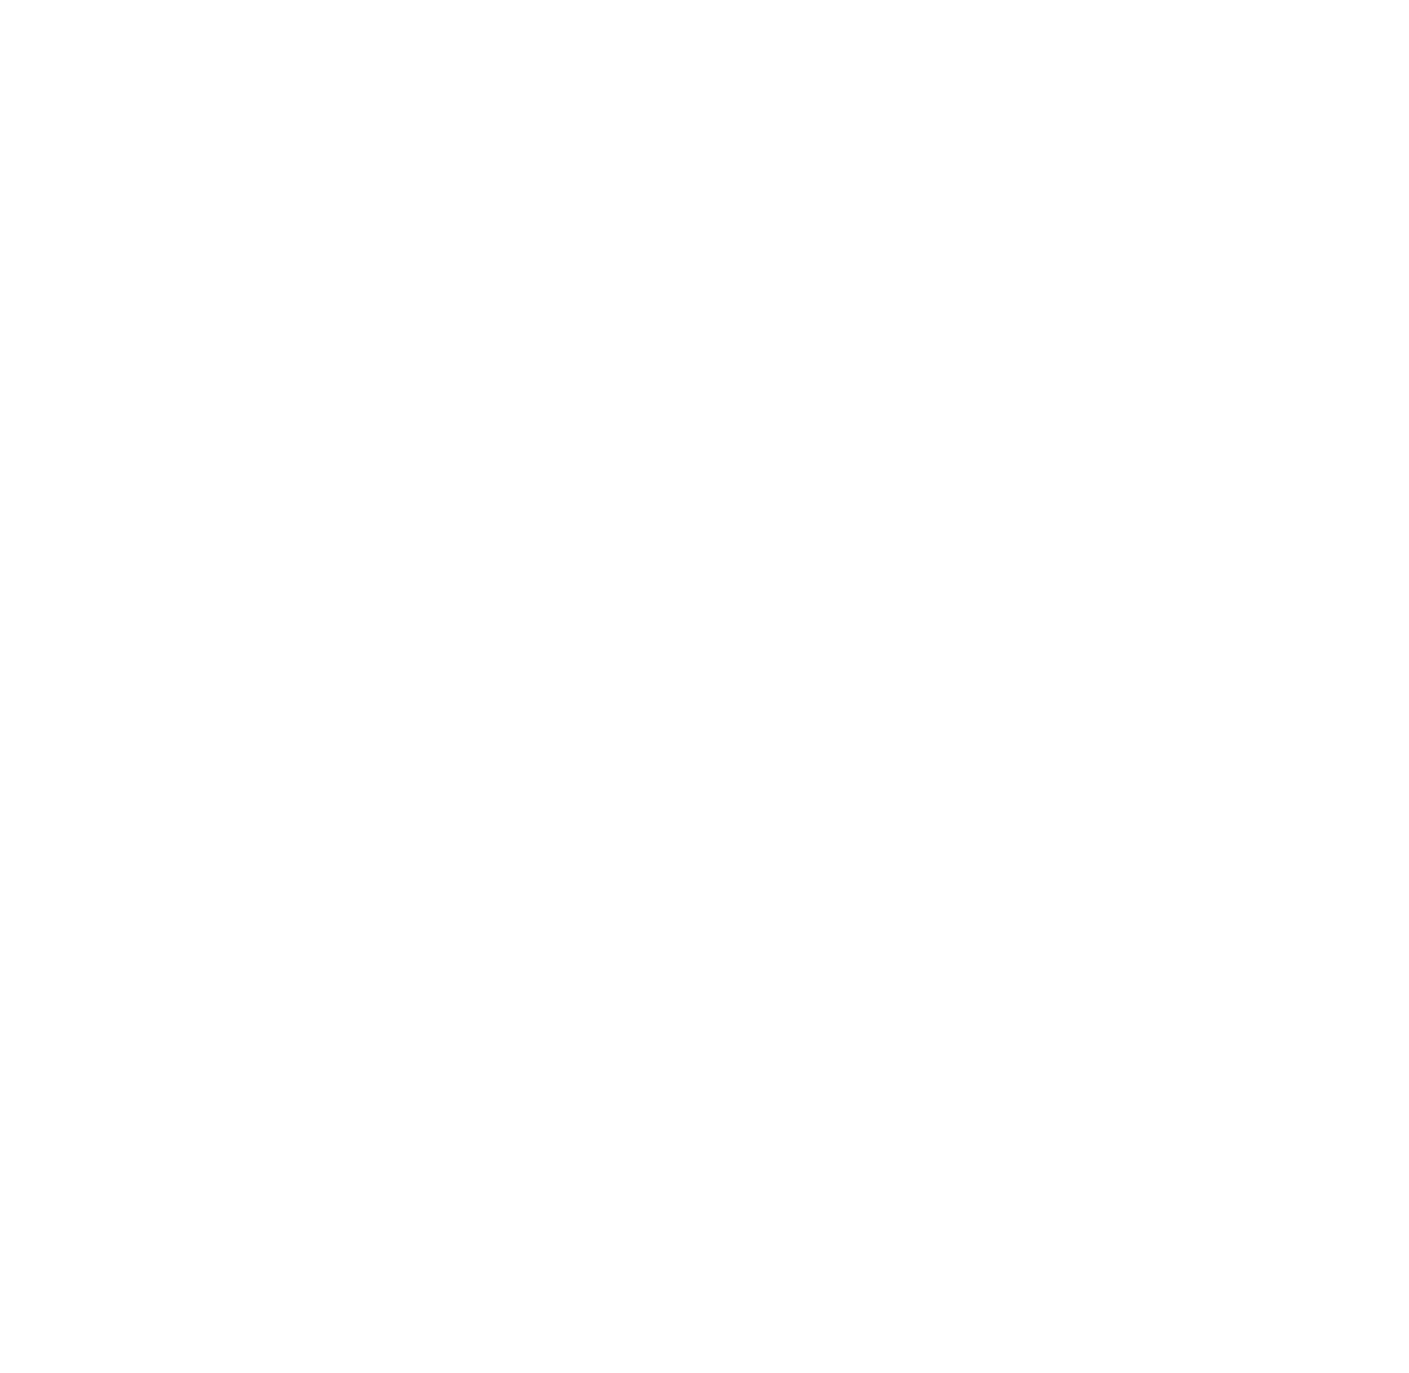

In [284]:
#highlight the nodes of convicted Enron officials
labels = {}
for node in graph.nodes():
    if node in key_nodes:
        labels[node] = node

plt.figure(figsize=(25,25))
nx.draw_networkx_nodes(graph, pos, node_size=6, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(graph, pos, alpha=0.3)
for key in key_nodes:
    nx.draw_networkx_labels(graph, pos, labels, node_color='r', node_size='25', font_size=12, font_color='r')
plt.figure(figsize=(25,25))
plt.axis('off')
plt.show(graph)